In [3]:
import boto3
import pandas as pd
import plotly.graph_objects as go
import io
import os
from dotenv import load_dotenv
import toml

app_config = toml.load('config_file.toml')
S3_BUCKET = app_config['aws']['bucket_name']
REGION = app_config['aws']['aws_region']
S3_PREFIX = ""  # If your files are stored under e.g. weather/yyyy/mm/dd/
METRICS = ["temp_celsius", "humidity", "cloud_cover", "precipitation_mm", "wind_speed_kph", "uv_index"]
MAPBOX_TOKEN = os.getenv('MAPBOX_TOKEN')
ACCESS_KEY = os.getenv('ACCESS_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')

temperature_colorscale = [
    [0.0, "rgb(0, 0, 255)"],       # Blue
    [1.0, "rgb(255, 0, 0)"]        # Red
]

precipitation_colorscale = [
    [0.0, "rgb(173, 216, 230)"],   # Light blue
    [1.0, "rgb(0, 0, 139)"]        # Dark blue
]

wind_speed_colorscale = [
    [0.0, "rgb(216, 191, 216)"],   # Light purple (thistle)
    [1.0, "rgb(128, 0, 128)"]      # Dark purple
]

uv_index_colorscale = [
    [0.0, "rgb(255, 255, 0)"],     # Yellow
    [1.0, "rgb(255, 0, 0)"]        # Red
]

humidity_colorscale = [
    [0.0, "rgb(173, 216, 230)"],   # Light blue
    [1.0, "rgb(0, 0, 139)"]        # Dark blue
]

cloud_cover_colorscale = [
    [0.0, "rgb(211, 211, 211)"],   # Light grey
    [1.0, "rgb(64, 64, 64)"]        # Dark grey
]

custom_colorscale_dict = {
    "temp_celsius": temperature_colorscale,
    "precipitation_mm": precipitation_colorscale,
    "wind_speed_kph": wind_speed_colorscale,
    "uv_index": uv_index_colorscale,
    "humidity": humidity_colorscale,
    "cloud_cover": cloud_cover_colorscale
}

# Initialize S3
s3 = boto3.client("s3", 
                  region_name=REGION,
                  aws_access_key_id=ACCESS_KEY,
                  aws_secret_access_key=SECRET_KEY)

# List all .parquet files in the path
def list_parquet_files(bucket, prefix):
    paginator = s3.get_paginator('list_objects_v2')
    files = []

    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get("Contents", []):
            if obj["Key"].endswith(".parquet"):
                files.append(obj["Key"])
    return files

# Download and load all files into one DataFrame
def load_all_parquet(bucket, keys):
    dfs = []
    for key in keys:
        obj = s3.get_object(Bucket=bucket, Key=key)
        buffer = io.BytesIO(obj["Body"].read())
        df = pd.read_parquet(buffer)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Plot heatmap with dropdown
def plot_heatmap(df, metrics):
    import plotly.graph_objects as go
    traces = []
    for metric in metrics:
        traces.append(
            go.Scattermapbox(
                lat=df["latitude"],
                lon=df["longitude"],
                mode="markers",
                marker=dict(
                    size=30,  # Make dots bigger
                    color=df[metric],
                    colorscale=custom_colorscale_dict.get(metric, "Viridis"),
                    cmin=df[metric].min(),
                    cmax=df[metric].max(),
                    colorbar=dict(title=metric.capitalize())
                ),
                name=metric,
                visible=(metric == metrics[0]),
                hovertext=df[metric].round(2).astype(str),  # Show value
                hoverinfo="text"
            )
        )

    # Dropdown menu
    buttons = []
    for i, metric in enumerate(metrics):
        visible = [False] * len(metrics)
        visible[i] = True
        buttons.append(dict(
            label=metric.capitalize(),
            method="update",
            args=[{"visible": visible},
                  {"title": f"Weather Heatmap - {metric.capitalize()}"}]
        ))

    fig = go.Figure(data=traces)
    fig.update_layout(
        title=f"Weather Heatmap - {metrics[0].capitalize()}",
        mapbox=dict(
            center=dict(lat=49.5, lon=-122.5),
            zoom=8,
            style="open-street-map"
        ),
        updatemenus=[dict(
            buttons=buttons,
            direction="down",
            x=0.05,
            y=1.15,
            showactive=True
        )],
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )

    fig.show()

Listing parquet files from S3...
Found 25 files
Loading data...
Loaded 2749 records
After grouping, there exists 985 unique points.


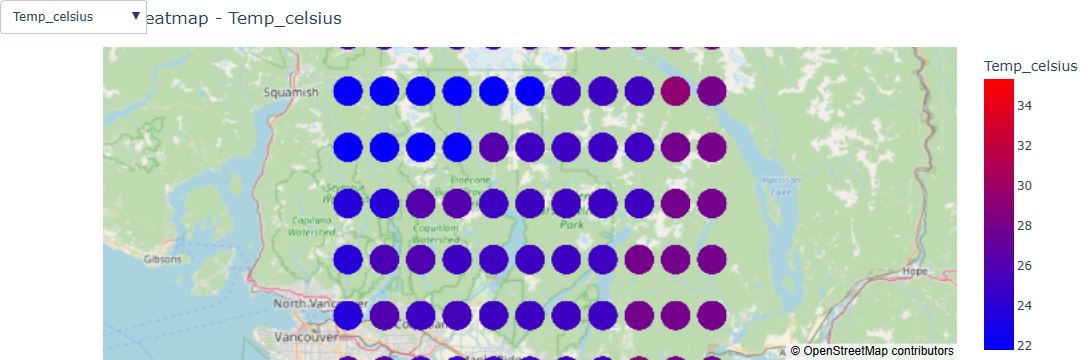

In [4]:
print("Listing parquet files from S3...")
parquet_keys = list_parquet_files(S3_BUCKET, S3_PREFIX)
print(f"Found {len(parquet_keys)} files")

agg_funcs = {
    "temp_celsius": "mean",
    "humidity": "mean",
    "precipitation_mm": "sum",     # <- only summed one
    "cloud_cover": "mean",
    "wind_speed_kph": "mean",
    "uv_index": "mean"
}

if parquet_keys:
    print("Loading data...")
    df = load_all_parquet(S3_BUCKET, parquet_keys)
    
    print(f"Loaded {len(df)} records")
    # Group by and average for df
    df_grouped = df.groupby(['latitude', 'longitude', 'updated_time'], as_index=False).agg(agg_funcs).reset_index()
    print(f"After grouping, there exists {len(df_grouped)} unique points.")
    plot_heatmap(df_grouped, METRICS)